# 🛣️ Developing a recommendation products algorithm (Markov Chains)

In this notebook, I will develop a data-driven approach to product bundling, offering customers relevant bundles that align with their purchasing patterns. This not only increases the likelihood of additional sales but also enhances the overall customer experience by providing tailored product recommendations.

I will be leveraging data from `The Instacart Online Grocery Shopping Dataset 2017`.

Data taken from : [Instacart](https://www.instacart.com/datasets/grocery-shopping-2017)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse

from rankmc.data.etl import datafile_path_finder, stratified_sample
from rankmc.model.markovchain import prepare_df_for_sparse_matrix, create_sparse_matrix, init_state_mc, eval_markov_chain, create_mc_df

# 1. Load the data

For this project I will be using `2 tables` the `products` where we have the information of the products and the `orders` of products by the users.

In [2]:
# define the data file paths
dir_products = datafile_path_finder('products.csv')
dir_order_products = datafile_path_finder('order_products.csv')

In [3]:
products = pd.read_csv(dir_products)
# index will be used to join with order_products
products['index'] = products.index
products.head(2)

,product_id,product_name,aisle_id,department_id,index
0,1,Chocolate Sandwich Cookies,61,19,0
1,2,All-Seasons Salt,104,13,1


In [4]:
order_products = pd.read_csv(dir_order_products)
order_products.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1


In [5]:
order_products.shape

(33819106, 4)

Due to the large number of data in orders tables this will need be resample.

# 2. Sample the data

In [6]:
size = 50000
order_products = stratified_sample(order_products, 'order_id', size)
order_products.shape

(505114, 4)

# 3. Analysis of data

### Explore Size of Sampled data

How many orders do we have in the dataset?

In [7]:
len(order_products['order_id'].unique())

50000

How many unique products we have in orders?

In [8]:
len(order_products['product_id'].unique())

29347

How many items are within each order?

In [9]:
order_products[['add_to_cart_order']].describe().T

,count,mean,std,min,25%,50%,75%,max
add_to_cart_order,505114.0,8.357888,7.142076,1.0,3.0,6.0,11.0,98.0


What is the order size distribution?

In [10]:
order_group = order_products.groupby('order_id')['product_id'].count().reset_index()

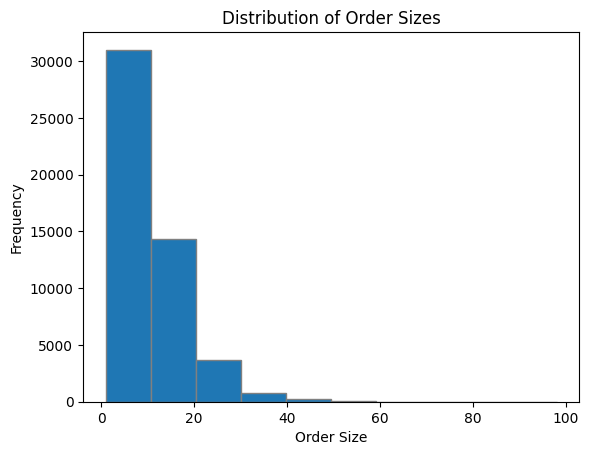

In [11]:
# Creating histogram
plt.hist(order_group['product_id'], edgecolor="gray")

# Adding extra features    
plt.xlabel("Order Size")
plt.ylabel("Frequency")
plt.title('Distribution of Order Sizes')
plt.show()


Zooming in to the buckets

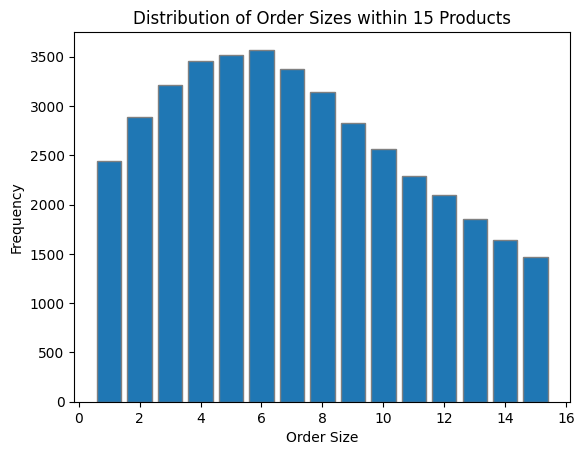

In [12]:
# Creating histogram
df_group_hist = order_group.loc[order_group['product_id']<16, 'product_id']

plt.hist(df_group_hist, bins=range(min(df_group_hist), max(df_group_hist) + 2), edgecolor="gray",align='left', rwidth=0.8)

# Adding extra features    
plt.xlabel("Order Size")
plt.ylabel("Frequency")
plt.title('Distribution of Order Sizes within 15 Products')
plt.show()

From the above chart most orders are within 10 products and most of them have 6 products across all sized of checkouts

## Ranking Products by sales (inital)
Let's take a look at top ranked products in orders and compared later to the Markov Chain Model Rankings results

In [13]:
top_products = order_products.groupby('product_id').size().reset_index(name='count').sort_values(by= 'count', ascending = False)
top_products = top_products.merge(products, on = 'product_id', how = 'left').head(10)
top_products

,product_id,count,product_name,aisle_id,department_id,index
0,24852,7420,Banana,24,4,24851
1,13176,5819,Bag of Organic Bananas,24,4,13175
2,21137,4194,Organic Strawberries,24,4,21136
3,21903,3714,Organic Baby Spinach,123,4,21902
4,47209,3160,Organic Hass Avocado,24,4,47208
5,47766,2714,Organic Avocado,24,4,47765
6,47626,2362,Large Lemon,24,4,47625
7,16797,2242,Strawberries,24,4,16796
8,27845,2141,Organic Whole Milk,84,16,27844
9,26209,2114,Limes,24,4,26208


# 4. Create new features

Motivation - Banana is the top product, we will compare the above list to a new list generates by using Markov Chains based on the order patterns we observe. Following a general process:

1. Build Transistion Matrix
2. Evaluate Steady State of Markov Chain Model
3. Rank Products to Build bundles of products bought together

#### 1.Build Transistion Matrix
1. Create a column of the next ordered products within orders
2. Generate and add index to current products for matrix construction
3. Remove last rows of each order
4. Generate edge weights or probabilities
5. Build Sparse COO Matrix

In [14]:
df_prepared_sm = prepare_df_for_sparse_matrix(order_products, 'order_id', 'product_id', products)
df_prepared_sm.head(10)

,order_id,product_id_x,add_to_cart_order,reordered,shifted_id,index_x,product_id_y,index_y,_merge,OUTDEGREE,WEIGHT
0,32,12384,1,1,15991.0,12383,15991.0,15990.0,both,107,0.009346
1,32,15991,2,0,13176.0,15990,13176.0,13175.0,both,6,0.166667
2,32,13176,3,1,20995.0,13175,20995.0,20994.0,both,5386,0.000186
3,32,20995,4,1,18362.0,20994,18362.0,18361.0,both,451,0.002217
4,32,18362,5,0,35887.0,18361,35887.0,35886.0,both,339,0.002950
5,32,35887,6,0,49683.0,35886,49683.0,49682.0,both,139,0.007194
6,32,49683,7,1,4920.0,49682,4920.0,4919.0,both,1357,0.000737
7,32,4920,8,0,28199.0,4919,28199.0,28198.0,both,1174,0.000852
8,185,23165,1,1,24964.0,23164,24964.0,24963.0,both,297,0.003367
9,185,24964,2,1,39812.0,24963,39812.0,39811.0,both,1614,0.000620


In [15]:
# Find the count of distinct product IDs across the two specified columns
n_actual = len(set(df_prepared_sm['product_id_x']) | set(df_prepared_sm['shifted_id']))
n_actual

29295

In [16]:
# validate the join
df_prepared_sm['_merge'].value_counts(dropna=False)

_merge
both          455114
left_only          0
right_only         0
Name: count, dtype: int64

## 5. Build Sparse COO Matrix

In [17]:
P, n = create_sparse_matrix(df_prepared_sm, products)

In [18]:
def spy(A, figsize=(20, 20), markersize=0.5):
    """Visualizes a sparse matrix."""
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.title("The different combinations of products")
    plt.show()

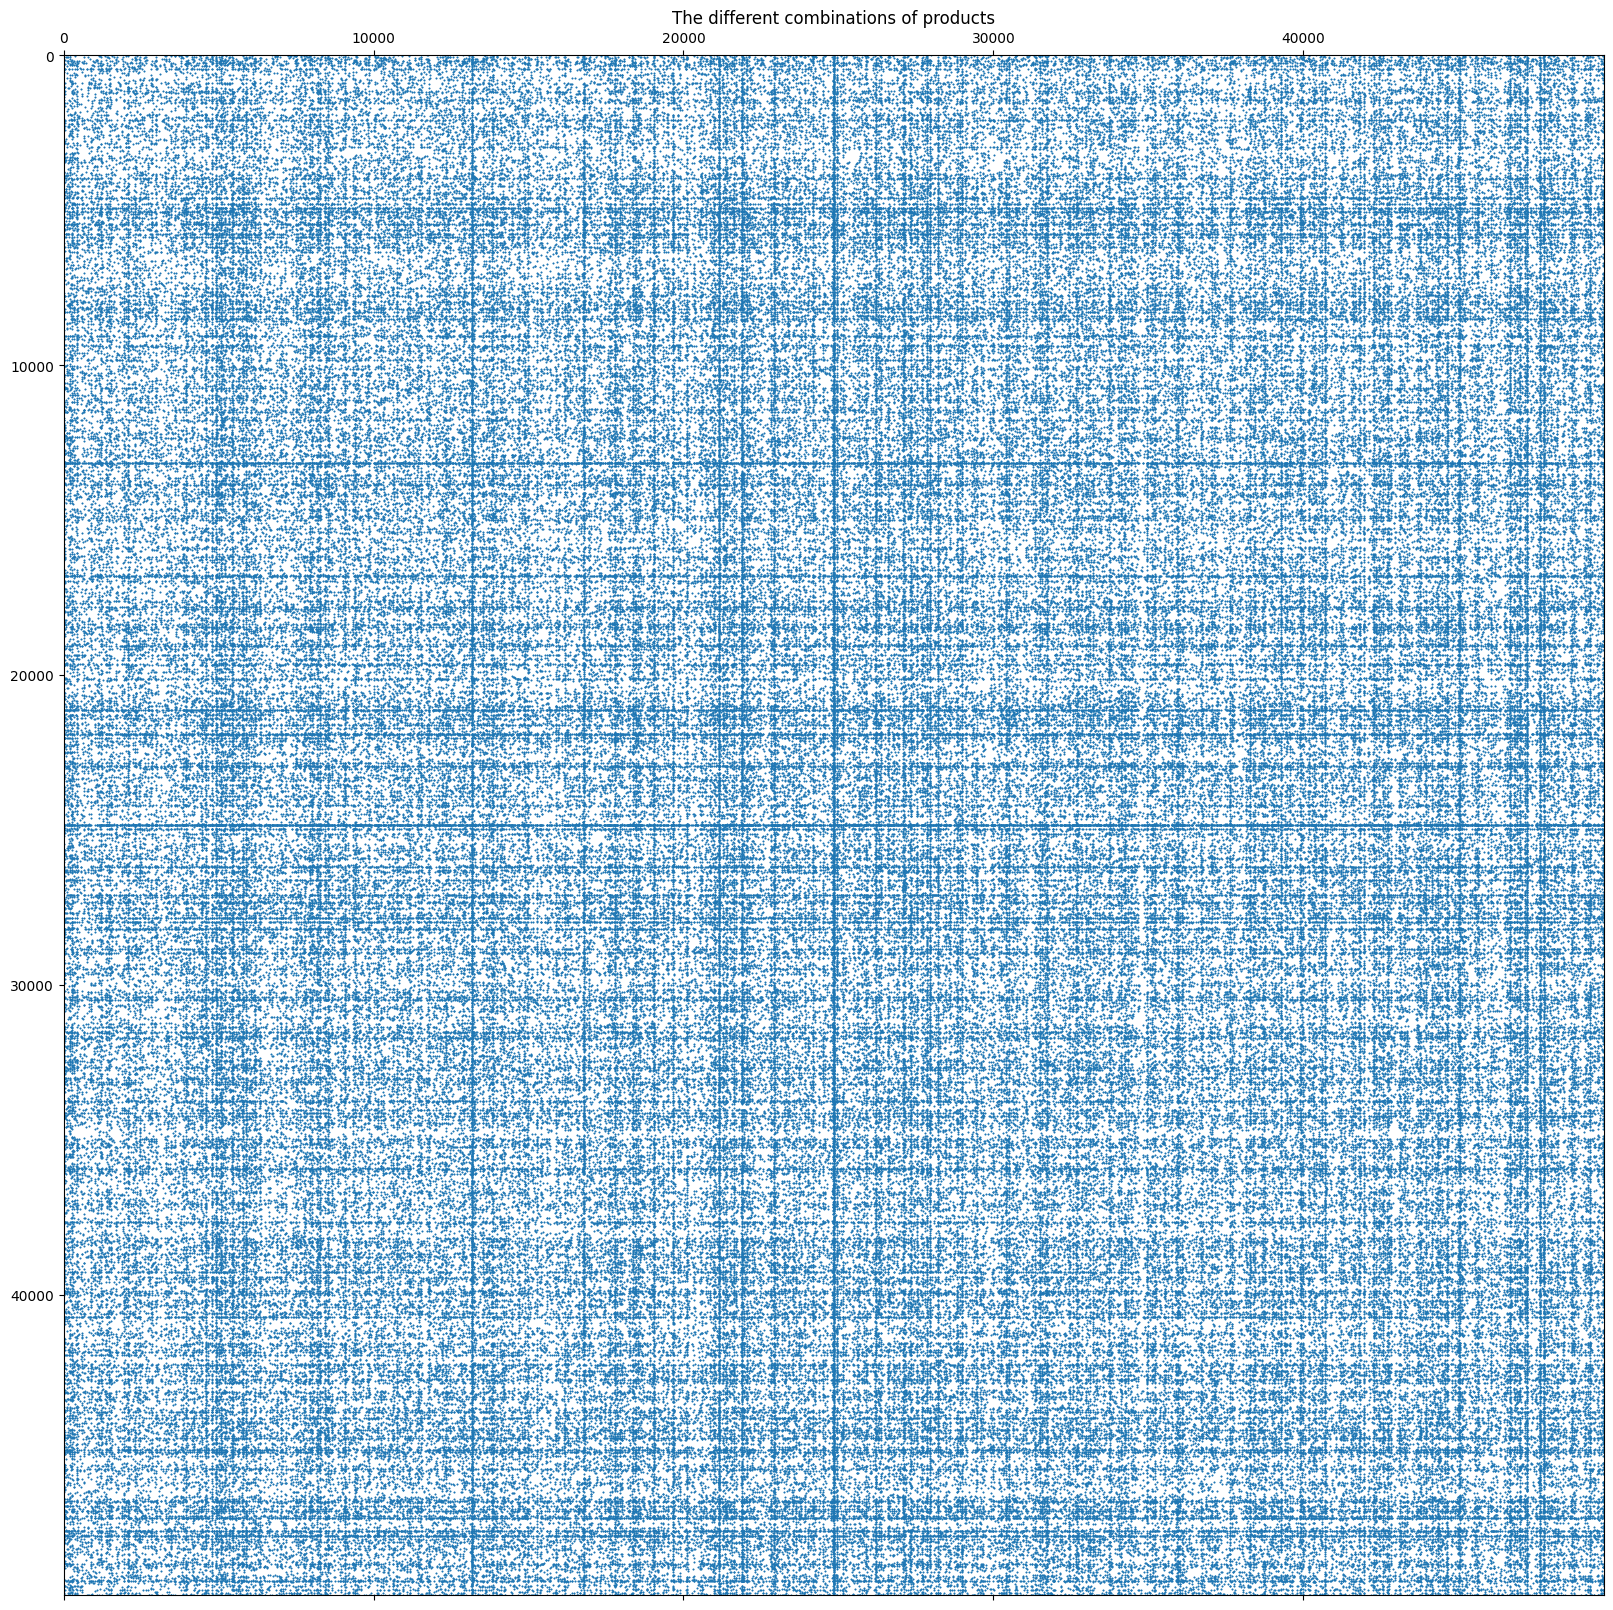

In [19]:
spy(P)

# 5. Train Steady State of Markov Chain Model

Initialize state in markov chain

In [20]:
x0 = init_state_mc(df_prepared_sm, n)
x0.shape

(49688,)

In [21]:
# Visually inspect your result:
def display_vec_sparsely(x, name='x'):
    i_nz = np.argwhere(x).flatten()
    df_x_nz = pd.DataFrame({'i': i_nz, '{}[i] (non-zero only)'.format(name): x[i_nz]})
    display(df_x_nz.head())
    print("...")
    display(df_x_nz.tail())
    
display_vec_sparsely(x0, name='x0')

,i,x0[i] (non-zero only)
0,0,0.00002
1,1,0.00002
2,2,0.00002
3,3,0.00002
4,5,0.00002


...


,i,x0[i] (non-zero only)
28092,49680,0.00002
28093,49681,0.00002
28094,49682,0.00002
28095,49684,0.00002
28096,49685,0.00002


In [22]:
T_MAX = 10**4
x, tv_distances = eval_markov_chain(P, x0, T_MAX)
x.shape

(49688,)

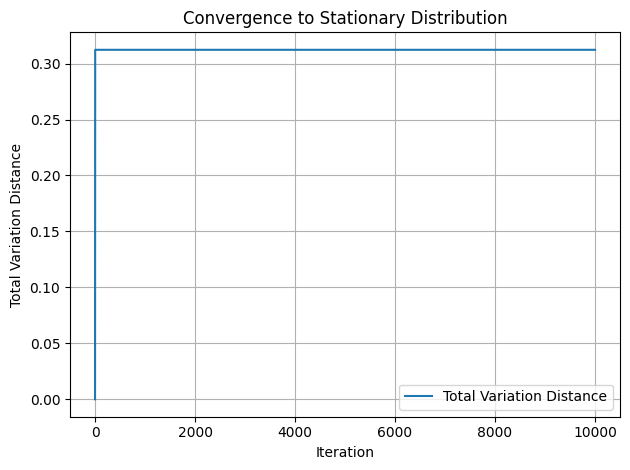

In [23]:
# Plot Total Variation Distance
plt.plot()
plt.plot(tv_distances, label='Total Variation Distance')
plt.xlabel('Iteration')
plt.ylabel('Total Variation Distance')
plt.title('Convergence to Stationary Distribution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 6. Rank Products to Build bundles of Products Bought Together

In [24]:
df_mc = create_mc_df(x, products)
df_mc = df_mc.drop(columns=['aisle_id', 'department_id'])

df_mc.head(10)

,index,ss_prob,rank,product_id,product_name
0,24851,0.005066,1,24852,Banana
1,13175,0.003070,2,13176,Bag of Organic Bananas
2,21136,0.002369,3,21137,Organic Strawberries
3,21902,0.002045,4,21903,Organic Baby Spinach
4,16796,0.001718,5,16797,Strawberries
5,47208,0.001701,6,47209,Organic Hass Avocado
6,47765,0.001602,7,47766,Organic Avocado
7,26208,0.001447,8,26209,Limes
8,47625,0.001411,9,47626,Large Lemon
9,27965,0.001331,10,27966,Organic Raspberries


### Final Ranking Comparrison

In [25]:
df_f = df_mc.merge(top_products, on = 'product_id', how ='left').head(10)
df_f = df_f.drop(columns=['aisle_id', 'department_id', 'index_y'])

df_f.rename(columns  = {'index_x': 'index','product_name_x': 'MC_Product', 'product_name_y': 'Initial_Ranking'})

,index,ss_prob,rank,product_id,MC_Product,count,Initial_Ranking
0,24851,0.005066,1,24852,Banana,7420.0,Banana
1,13175,0.003070,2,13176,Bag of Organic Bananas,5819.0,Bag of Organic Bananas
2,21136,0.002369,3,21137,Organic Strawberries,4194.0,Organic Strawberries
3,21902,0.002045,4,21903,Organic Baby Spinach,3714.0,Organic Baby Spinach
4,16796,0.001718,5,16797,Strawberries,2242.0,Strawberries
5,47208,0.001701,6,47209,Organic Hass Avocado,3160.0,Organic Hass Avocado
6,47765,0.001602,7,47766,Organic Avocado,2714.0,Organic Avocado
7,26208,0.001447,8,26209,Limes,2114.0,Limes
8,47625,0.001411,9,47626,Large Lemon,2362.0,Large Lemon
9,27965,0.001331,10,27966,Organic Raspberries,NaN,NaN


## 7. Conclusion

Based on both rankings markov chains model and from the initial counts of sales they shown to be similar. I was expecting the ranking to show quite different products however given that this is smaller dataset the results might change with the extended dataset.

Overall, with the current results I would recommend and add these 10 products some where in the view of the shopper to potentially remind them of products that customers tend to buy together.

Also, I would consider adding this products with other to increase sales.